### Modules

In [1]:
import json

import psycopg2 as psyc
import pandas as pd
import numpy as np
from statsmodels.stats.weightstats import ttest_ind
import datetime
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

### ETL

In [2]:
# saved database connection data as a hidden json file, for confidentiality 
with open("/Users/lucasramadan/SCL-Work/.db_conn.json", 'r') as f:
    db_conn = json.load(f)

In [3]:
# create the connection
# unpacking the arguments
conn = psyc.connect(**db_conn)

In [4]:
cur = conn.cursor()

In [5]:
# query to gather metrics 
with open('/Users/lucasramadan/SCL-Work/Travel_Time_Metrics.sql') as f:
    q = f.read()

In [6]:
cur.execute(q)

In [7]:
data = cur.fetchall()

In [8]:
data = np.asarray(data)

In [9]:
data[0]

array([datetime.date(2016, 9, 26), '1-BAY', 28.0299242459463,
       27.5219791703754, 10.8069751170431, 41.5387256088415], dtype=object)

In [9]:
cols = ['market', 'vtt', 'ptt', 'pttpv', 'ttt']

In [10]:
df = pd.DataFrame(data[:, 1:], index=data[:, 0], columns=cols)
df.head()

,market,vtt,ptt,pttpv,ttt
2016-09-26,1-BAY,28.0299,27.522,10.807,41.5387
2016-09-26,2-NY,36.3322,26.2688,11.9568,43.4737
2016-09-26,4-LA,27.1992,32.2527,13.1176,37.8268
2016-09-26,5-CHI,48.9582,42.0592,19.8766,53.1555
2016-09-26,6-DAL,29.8821,31.6354,20.7796,44.1001


### Filtering and Segmentation

In [11]:
logic_change_date = datetime.date(2016, 11, 18)

# we're just going to look two weeks on either side of the logic_change date

low_date = logic_change_date - datetime.timedelta(days=14)
high_date = logic_change_date + datetime.timedelta(days=14)

In [12]:
markets = sorted(list(set(df['market'].values)))
markets

['1-BAY', '2-NY', '4-LA', '5-CHI', '6-DAL', '7-HOU', '8-ATL', '9-MIA']

In [13]:
# modified for just two weeks on either side
df = df[df.index > low_date]
df = df[df.index < high_date]

In [14]:
# making a lookup table for adding to later
location_dfs = {market: {'data': df[df['market'] == market]} for market in markets}

In [15]:
# take a look at one of the market level dfs
location_dfs['1-BAY']['data'].head()

,market,vtt,ptt,pttpv,ttt
2016-11-05,1-BAY,44.4175,31.961,15.6553,44.0238
2016-11-06,1-BAY,33.8873,19.1457,7.87376,39.9802
2016-11-07,1-BAY,34.7781,21.6487,8.84847,36.8697
2016-11-08,1-BAY,29.421,31.227,21.1106,49.8558
2016-11-09,1-BAY,31.4014,30.3565,21.4659,51.7104


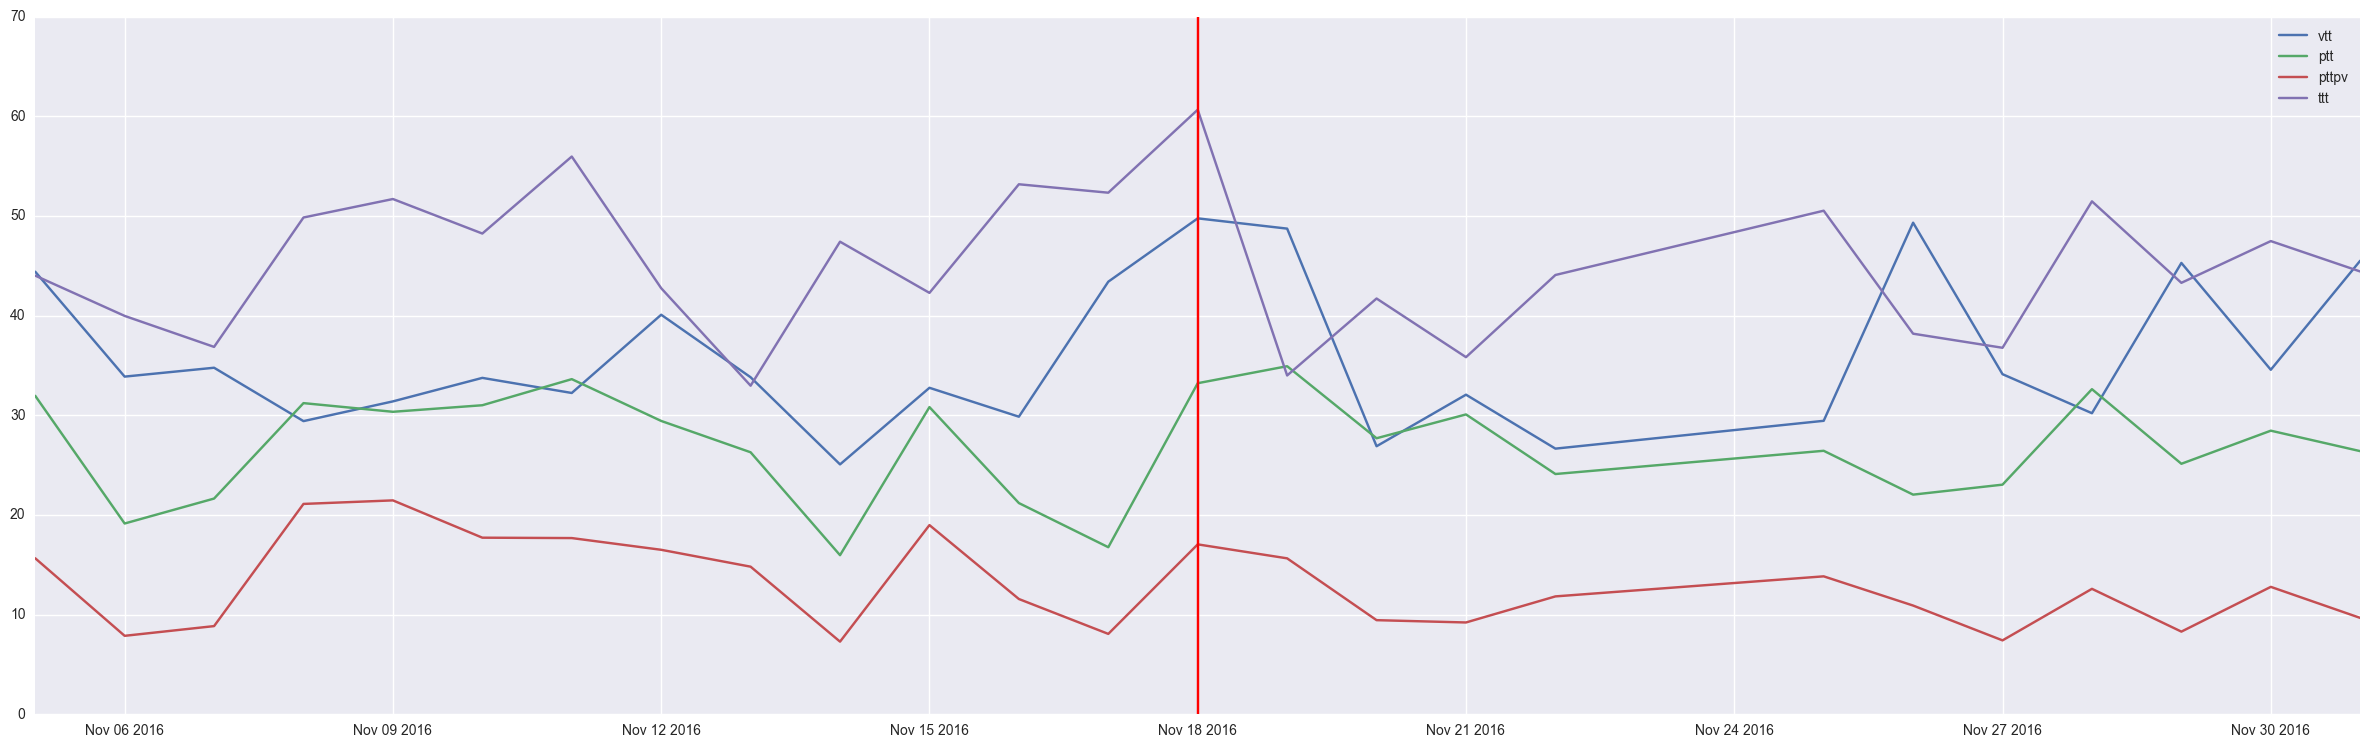

In [16]:
location_dfs['1-BAY']['data'].plot(figsize=(30, 9))
plt.axvline(logic_change_date, c='r');

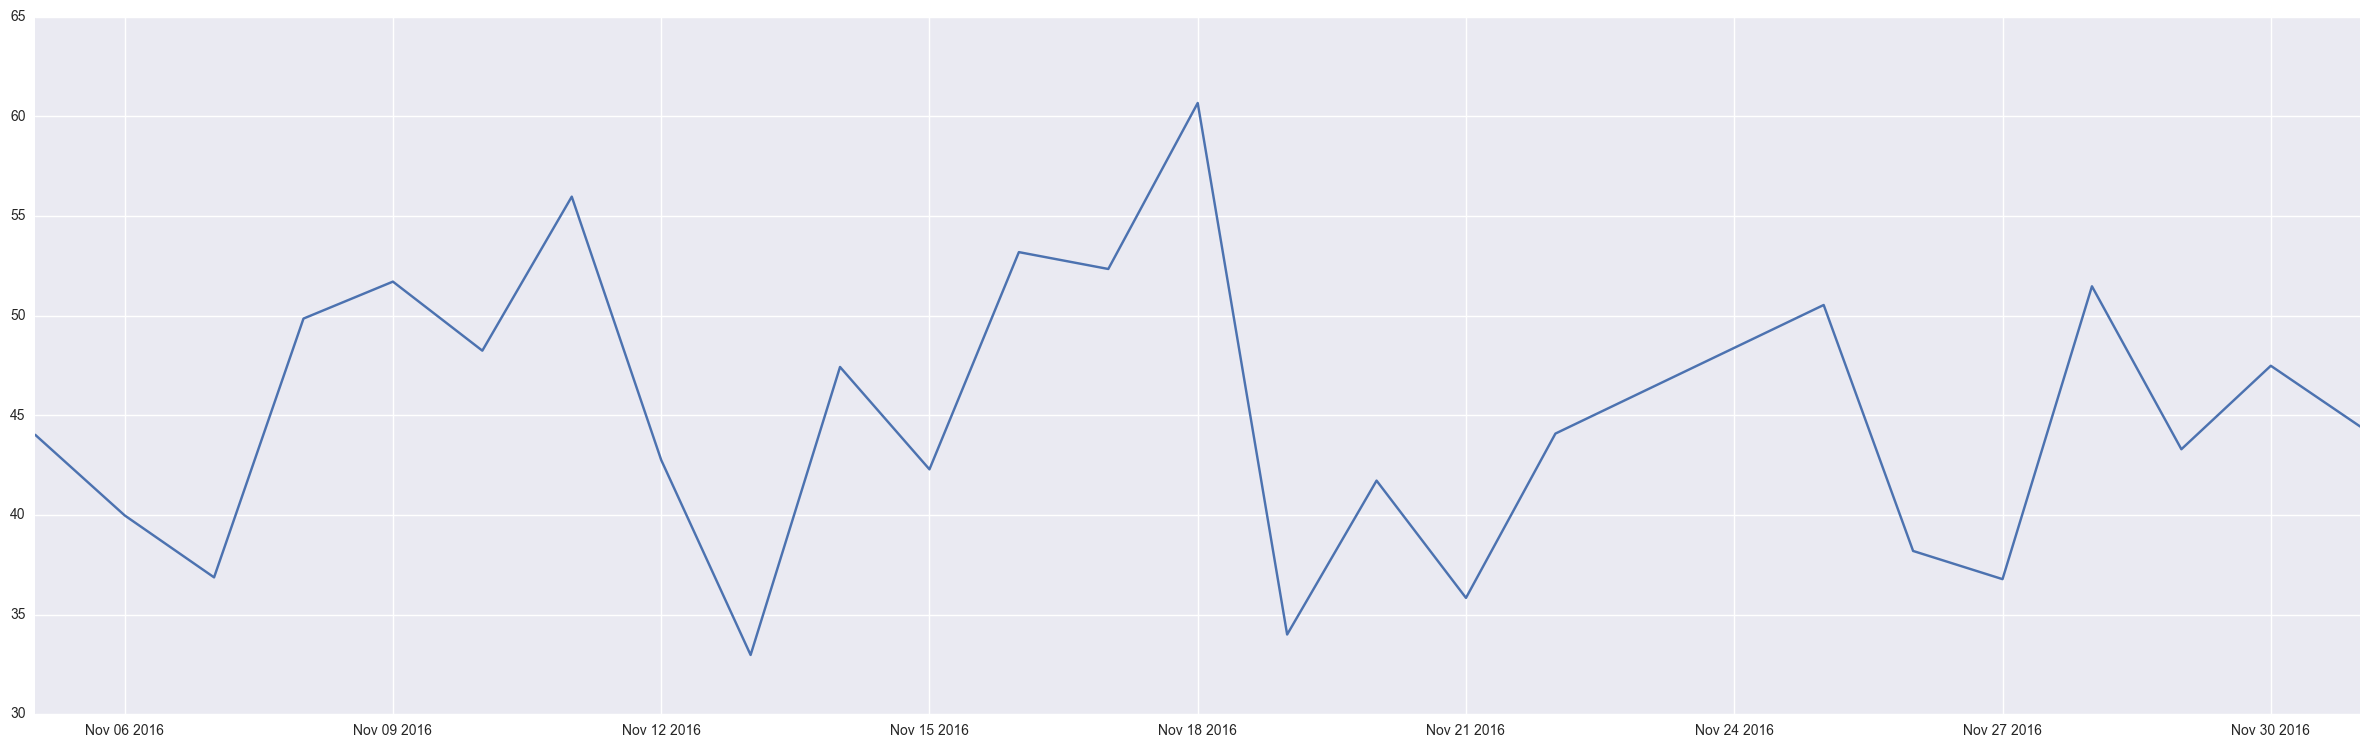

In [17]:
location_dfs['1-BAY']['data']['ttt'].plot(figsize=(30, 9));

### Statistical Analysis

In [18]:
# calculate before/after data split

for market in location_dfs:
    # before
    before_data = location_dfs[market]['data'][location_dfs[market]['data'].index < logic_change_date]
    location_dfs[market]['before'] = before_data
    
    # after
    after_data = location_dfs[market]['data'][location_dfs[market]['data'].index > logic_change_date]
    location_dfs[market]['after'] = after_data

In [19]:
location_dfs['1-BAY'].keys()

['after', 'data', 'before']

In [22]:
location_dfs['1-BAY']['before']['ttt'].mean()

45.973223570061869

In [21]:
location_dfs['1-BAY']['after']['ttt'].mean()

42.533460288686108

In [31]:
for market in location_dfs:
    # alias -- remember to drop market column for calculations below
    before = location_dfs[market]['before']
    before.drop('market', axis=1, inplace=True)
    after = location_dfs[market]['after']
    after.drop('market', axis=1, inplace=True)
    
    # calculate summary stats
    
    before_summary = [np.mean(before[metric].values) for metric in before.columns] 
    after_summary = [np.mean(after[metric].values) for metric in after.columns]

    stats = [ttest_ind(before[metric].values, after[metric].values, usevar='unequal') for metric in before.columns]

    stats = np.asarray(stats).T

    all_values = [before_summary, after_summary] + list(list(s) for s in stats)

    summary = pd.DataFrame(all_values, 
                             columns=before.columns, 
                             index=['before', 'after', 't_score', 'p_value', 'df'])
    
    # finally, save to each market in our lookup
    location_dfs[market]['summary'] = summary

/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/lucasramadan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Finally, view the statistical summaries by Market

In [32]:
# simple viewing
for market in markets:
    print market
    print
    print '-'*60
    print location_dfs[market]['summary'].head()
    print '-'*60
    print

1-BAY

------------------------------------------------------------
               vtt        ptt      pttpv        ttt
before   34.227138  26.113699  14.430129  45.973224
after    36.627202  27.364093  11.059117  42.533460
t_score  -0.781892  -0.590585   2.088837   1.323878
p_value   0.445562   0.561250   0.051146   0.199142
df       16.191897  20.511512  18.061404  21.990164
------------------------------------------------------------

2-NY

------------------------------------------------------------
               vtt        ptt      pttpv        ttt
before   33.336541  26.122684  17.484649  47.881205
after    32.065987  26.501516  14.394310  40.584234
t_score   0.692014  -0.183687   1.687456   2.234684
p_value   0.500059   0.856624   0.108678   0.038004
df       14.237656  15.606103  18.094217  18.481075
------------------------------------------------------------

4-LA

------------------------------------------------------------
               vtt        ptt      pttpv        tt

In [33]:
# pick out where we had a positive impact

metrics = cols[1:]

for market in markets:
    print market
    print 
    
    t_scores = location_dfs[market]['summary'].ix['t_score']
    p_values = location_dfs[market]['summary'].ix['p_value']
    
    for i, (t_score, p_value) in enumerate(zip(t_scores, p_values)):
        if t_score > 0:
            print '\t', metrics[i]
            print '\t\tt_score:', t_score, 
            print '\t\tp_value:', p_value
    
    print
    print '-'*80

1-BAY

	pttpv
		t_score: 2.08883664676 		p_value: 0.051146304053
	ttt
		t_score: 1.32387760688 		p_value: 0.199141715952

--------------------------------------------------------------------------------
2-NY

	vtt
		t_score: 0.692014472882 		p_value: 0.500058963141
	pttpv
		t_score: 1.68745619797 		p_value: 0.108677996226
	ttt
		t_score: 2.23468446335 		p_value: 0.0380044169069

--------------------------------------------------------------------------------
4-LA

	pttpv
		t_score: 2.42915021813 		p_value: 0.0241449415727

--------------------------------------------------------------------------------
5-CHI


--------------------------------------------------------------------------------
6-DAL

	ptt
		t_score: 0.953552397961 		p_value: 0.357449003103
	pttpv
		t_score: 1.73057490747 		p_value: 0.106359953024

--------------------------------------------------------------------------------
7-HOU

	ptt
		t_score: 0.517130941818 		p_value: 0.610227965223
	pttpv
		t_score: 2.40730742095 	

In [34]:
# finally close the connection
conn.close()